# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
- convert the tracksters into some latent space and predict a link between them

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, f1_score, fbeta_score

from reco.dataset import TracksterPairs

In [2]:
# Apple silicon setup
# this ensures that the current MacOS version is at least 12.3+
# print(torch.backends.mps.is_available())
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
ds = TracksterPairs("data", N_FILES=10, balanced=True, include_neutral=False, MAX_DISTANCE=15, ENERGY_THRESHOLD=20)
ds.x.shape

torch.Size([22610, 31])

In [5]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [6]:
print(ds.x.shape)
print("Positive:", int((ds.y == 1).type(torch.int).sum()))
print("Neutral:", int((ds.y == 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y == 0).type(torch.int).sum()))

torch.Size([22610, 31])
Positive: 11305
Neutral: 0
Negative: 11305


In [7]:
print("dataset balance:", float(sum(ds.y) / len(ds.y))) 

dataset balance: 0.5


In [8]:
loss_obj = torch.nn.BCELoss()

def train(model, opt, loader):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == labels.type(torch.int))
    return (correct / total)

In [9]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 20349, Test samples: 2261


In [10]:
model = nn.Sequential(
    nn.Linear(ds.x.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Dropout(),
    nn.Sigmoid()
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

for epoch in range(0, 101):
    loss = train(model, optimizer, train_dl)
    scheduler.step()
    if epoch % 20 == 0:
        train_acc = test(model, train_dl)
        test_acc = test(model, test_dl)
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 0, loss: 165.4197, train acc: 0.9004, test acc: 0.8930
Epoch: 20, loss: 131.8878, train acc: 0.9502, test acc: 0.9385
Epoch: 40, loss: 127.5842, train acc: 0.9602, test acc: 0.9403
Epoch: 60, loss: 126.1608, train acc: 0.9654, test acc: 0.9385
Epoch: 80, loss: 126.2822, train acc: 0.9680, test acc: 0.9394
Epoch: 100, loss: 122.3837, train acc: 0.9697, test acc: 0.9385


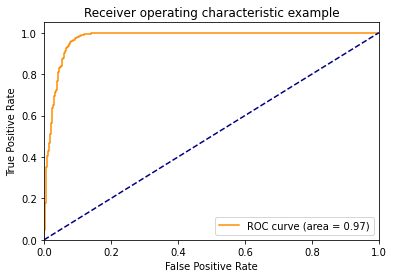

In [11]:
pred = []
lab = []
for b, l in test_dl:
    pred += model(b).tolist()
    lab += l.tolist()

fpr, tpr, _ = roc_curve(lab, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

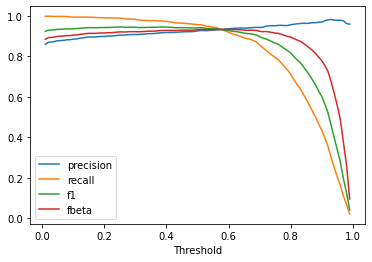

In [12]:
th_values = [i / 100. for i in range(1, 100)]
precision = []
recall = []
f1scores = []
fbeta = []

for th in th_values:
    pred = []
    lab = []
    for b, l in test_dl:
        pred += (model(b) > th).type(torch.int).tolist()
        lab += l.tolist()
    precision.append(precision_score(lab, pred))
    recall.append(recall_score(lab, pred))
    f1scores.append(f1_score(lab, pred))
    fbeta.append(fbeta_score(lab, pred, beta=0.5))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, f1scores, label="f1")
plt.plot(th_values, fbeta, label="fbeta")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [13]:
decision_th = 0.6

pred = []
lab = []
for b, l in test_dl:
    pred += (model(b) > decision_th).type(torch.int).tolist()
    lab += l.tolist()

tn, fp, fn, tp = confusion_matrix(lab, pred).ravel()
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
acc = accuracy_score(lab, pred)
precision = precision_score(lab, pred)
recall = recall_score(lab, pred)
f1 = f1_score(lab, pred)
fb = fbeta_score(lab, pred, beta=0.5)
print(f'Acc: {acc:.4f} P: {precision:.4f} R: {recall:.4f} F1: {f1:.2f} FB: {fb:.2f}')

TP: 1075, TN: 1021, FP: 72, FN: 93
Acc: 0.9270 P: 0.9372 R: 0.9204 F1: 0.93 FB: 0.93


# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [14]:
import uproot
import numpy as np
from reco.evaluation import pairwise_model_evaluation

file_name = "~/Data/multi/new_ntuples_14992862_991.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [15]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graphs,
    model,
    scaler,
    decision_th,
    max_distance=15,
    energy_threshold=20,
)

Event 0:
	clue3d_to_sim:	P: 0.95 R: 0.32 F: 0.37
	target_to_sim:	P: 0.97 R: 0.76 F: 0.79
	reco_to_target:	P: 0.99 R: 0.84 F: 0.87
	reco_to_sim:	P: 0.97 R: 0.65 F: 0.70
Event 1:
	clue3d_to_sim:	P: 0.97 R: 0.29 F: 0.34
	target_to_sim:	P: 0.98 R: 0.66 F: 0.71
	reco_to_target:	P: 0.89 R: 0.86 F: 0.87
	reco_to_sim:	P: 0.97 R: 0.66 F: 0.71
Event 2:
	clue3d_to_sim:	P: 0.99 R: 0.20 F: 0.24
	target_to_sim:	P: 0.99 R: 0.56 F: 0.61
	reco_to_target:	P: 0.89 R: 0.69 F: 0.72
	reco_to_sim:	P: 0.98 R: 0.45 F: 0.50
Event 3:
	clue3d_to_sim:	P: 0.96 R: 0.23 F: 0.27
	target_to_sim:	P: 0.98 R: 0.61 F: 0.66
	reco_to_target:	P: 0.82 R: 0.70 F: 0.72
	reco_to_sim:	P: 0.97 R: 0.53 F: 0.58
Event 4:
	clue3d_to_sim:	P: 0.95 R: 0.19 F: 0.23
	target_to_sim:	P: 0.97 R: 0.58 F: 0.63
	reco_to_target:	P: 0.92 R: 0.77 F: 0.79
	reco_to_sim:	P: 0.96 R: 0.52 F: 0.57
Event 5:
	clue3d_to_sim:	P: 0.99 R: 0.58 F: 0.63
	target_to_sim:	P: 0.99 R: 0.79 F: 0.83
	reco_to_target:	P: 0.97 R: 0.90 F: 0.92
	reco_to_sim:	P: 0.99 R: 0.71 

In [16]:
for key, values in result.items():
    avg_p = np.mean([x[0] for x in values])
    avg_r = np.mean([x[1] for x in values])
    avg_f = np.mean([x[2] for x in values])

    print(f"mean {key}:\tP: {avg_p:.2f} R: {avg_r:.2f} F: {avg_f:.2f}")

mean clue3d_to_sim:	P: 0.97 R: 0.30 F: 0.35
mean target_to_sim:	P: 0.97 R: 0.65 F: 0.69
mean reco_to_target:	P: 0.91 R: 0.80 F: 0.82
mean reco_to_sim:	P: 0.97 R: 0.58 F: 0.63
